# Classifying Burned Crop Residue
The following tutorial walks through the use of PlanetLabs daily imagery to classify pixels that have burned crop residue during the harvest seasons

### Import required packages

In [3]:
import os
import json
import rasterio
import fiona
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
from rasterio.warp import calculate_default_transform, reproject, Resampling
import seaborn as sb
from itertools import chain
import rasterio.mask
import geopandas as gpd
import gdal
from sklearn.metrics import accuracy_score,confusion_matrix, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import tsraster.model  as md
import tsraster.prep as tr
import pandas as pd
from tsraster.calculate import calculateFeatures, image_to_series, \
                                exportFeatures
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.preprocessing import StandardScaler
import numpy as np
from rasterstats import point_query

import dask
import dask.dataframe as dd
from dask.distributed import Client
from xml.dom import minidom

In [4]:
# set input data location
inpath = "../Images_new"

# get custom functions 
os.chdir(r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\NewCode')
from functions import merge_days, bai_rast_MS, ndvi_rast_MS, \
bai_rast_SR, ndvi_rast_SR, \
  merge_all_rast,find_unique_days,reproject_to_match, radiance_2_reflectance


## Merge daily images
The output from planetlabs is several different rasters as the area of interest will be over multiple images. This is due to how the imagery was taken. The images must be combined together through the process of merge.


### Create BAI and NDVI index
To create burned area index (BAI) and normalized difference vegetation index (NDVI) we need to first convert daily images from radience to reflectance values.  

Note: It is not clear that previous BAI index values map well to reflectance values in planet lab data.

In [3]:
# Calculate NDVI and BAI and write out images 
inpath = "../Images_new"

name_pattern ='MS.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*SR.tif']


# create NDVI and BAI for each day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))

    iterator = 0

    for an_image in a_day_images_filtered:
        
        print(an_image)
        # get coefficients to convert radiance to reflectance 
        r2r_dictionary = radiance_2_reflectance(an_image)
        
        bai_rast_MS(inpath=an_image, 
                 outpath=os.path.join(inpath,'bai',unique_day+"_"+str(iterator) + "_bai.tif"),
                r2r_dictionary = r2r_dictionary)
        
        ndvi_rast_MS(inpath=an_image, 
                 outpath=os.path.join(inpath,'ndvi',unique_day +"_"+str(iterator) + "_ndvi.tif"),
                 r2r_dictionary=r2r_dictionary)
        
        # write scaled reflectance values for false color composite exercise 
        write_reflectance(inpath=an_image, 
                  outpath=os.path.join(inpath,'reflectance',unique_day +"_"+str(iterator) + "_reflectance.tif"),
                  r2r_dictionary=r2r_dictionary)
        
        iterator= iterator + 1 

Unique Dates: ['20161126', '20161018', '20161121', '20161101', '20161213', '20161012', '20160828', '20161028', '20161027']
../Images_new\20161126_044358_0e3a\20161126_044358_0e3a_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.1688351437992264   0.43851275662066924
red band reflectance is 0.0 0.1688351437992264   0.360511272835371


C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\numpy\lib\function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


BAI band reflectance is nan nan   nan
../Images_new\20161126_044357_0e3a\20161126_044357_0e3a_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.16727972708370958   0.6504788621176562
red band reflectance is 0.0 0.16727972708370958   0.437366766126668
BAI band reflectance is nan nan   nan
../Images_new\20161018_044252_0e1f\20161018_044252_0e1f_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.182897913869688   0.465110209374264
red band reflectance is 0.0 0.182897913869688   0.334910320167153
BAI band reflectance is nan nan   nan
../Images_new\20161018_044250_0e1f\20161018_044250_0e1f_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.1929529551346526   0.4262744341568132
red band reflectance is 0.0 0.1929529551346526   0.4064222771731868
BAI band reflectance is nan nan   nan
../Images_new\20161018_044251_0e1f\20161018_044251_0e1f_3B_AnalyticMS.tif
nir band reflectance is 0.0 0.1886927503039692   0.425609841522368
red band reflectance is 0.0 0.1886927503039692   0.3899014167734158
BAI band ref

### Merge Same Day NDVI and BAI into Single File
Each day can have multiple image segments. Here we combine images from the same day into a single image for BAI and NDVI.

In [4]:
# MERGE SAME DAYS: Iterates through the unique list to select where files contain the same name 
#   and sets them up to be merged

# find all ndvi tifs 
name_pattern ='ndvi.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*MS.tif']

# merge by day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))
    
    # merge same days 
    merge_days(outpath  = "../Images_new/merge", 
               outname =   unique_day + "_ndvi_merge.tif",
               files_unique = a_day_images_filtered)



# find all bai tifs 
name_pattern ='bai.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*MS.tif']

# merge by day 
for unique_day in unique_days:
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))
    
    # merge same days 
    merge_days(outpath  = "../Images_new/merge", 
               outname =   unique_day + "_bai_merge.tif",
               files_unique = a_day_images_filtered)

Unique Dates: ['20161126', '20161018', '20161121', '20161101', '20161213', '20161012', '20160828', '20161028', '20161027']
File ../Images_new\ndvi\20161126_1_ndvi.tif
File ../Images_new\ndvi\20161126_0_ndvi.tif
mosiac shape:(1, 6992, 9549)
#################
Writing to ../Images_new/merge\20161126_ndvi_merge.tif
File ../Images_new\ndvi\20161018_1_ndvi.tif
File ../Images_new\ndvi\20161018_2_ndvi.tif
File ../Images_new\ndvi\20161018_0_ndvi.tif
mosiac shape:(1, 9731, 10105)
#################
Writing to ../Images_new/merge\20161018_ndvi_merge.tif
File ../Images_new\ndvi\20161121_2_ndvi.tif
File ../Images_new\ndvi\20161121_0_ndvi.tif
File ../Images_new\ndvi\20161121_1_ndvi.tif
mosiac shape:(1, 9602, 10022)
#################
Writing to ../Images_new/merge\20161121_ndvi_merge.tif
File ../Images_new\ndvi\20161101_1_ndvi.tif
File ../Images_new\ndvi\20161101_2_ndvi.tif
File ../Images_new\ndvi\20161101_0_ndvi.tif
mosiac shape:(1, 9719, 10032)
#################
Writing to ../Images_new/merge\201611

### Write Out Multi-Band Reflectance Values
It may also be helpful to collect raw reflectance values (not converted to NDVI or BAI) for use to generate training data or for use in training a classifier


In [ ]:
# Write out reflectance values
inpath = "../Images_new"

name_pattern ='reflectance.tif'
unique_days = find_unique_days(inpath, name_pattern )
bad_patterns = ['*DN_udm.tif','*merge.tif','*SR.tif','*aux.xml']


# create NDVI and BAI for each day 
for unique_day in unique_days:
    print('unique day:')
    print(unique_day)
    # get all images for day
    a_day_images = list(set(glob(os.path.join(inpath,'**/*'+ unique_day+'*'+name_pattern))))

    # remove all unwanted
    images_2_remove = [glob(os.path.join(inpath, '**/*'+unique_day+bad)) for bad in bad_patterns]
    images_2_remove = list(set(chain(*images_2_remove))) # unlist of lists 
    a_day_images_filtered = list(set(a_day_images) - set(images_2_remove))

    iterator = 0

    # store a day of image readers 
    src_files_to_mosaic = []    

    for an_image in a_day_images_filtered:
         
        src = rasterio.open(an_image)
        src_files_to_mosaic.append(src)    
    
    print('a day')
    print(src_files_to_mosaic)
    
    # merge a days image
    mosaic, out_trans = merge(datasets=src_files_to_mosaic )
        
    # Copy the metadata
    out_meta = src.meta.copy()
    
    # Update the metadata
    out_meta.update({"driver": "GTiff",
                      "height": mosaic.shape[1],
                      "width": mosaic.shape[2],
                      "transform": out_trans,
                      #"crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs "
                      }
                     )
    
    out_fp = os.path.join(inpath,'multiband_merge','multiband_'+unique_day+'.tif')
    
    with rasterio.open(out_fp, "w", **out_meta) as dest:
          dest.write(mosaic)    

### Create blank example raster
In order to compare images across time we need to generate images with the same dimensions, here of size (15503, 23783). All daily images will then be coerced to this shape.

In [5]:
#%% Create blank example raster with full extent of all images 

# Selects the files using a unique identifier and sets up the out paths
 
all_bai = glob(os.path.join(inpath,'**/*ndvi_merge.tif'))
outpath = os.path.join(inpath ,'combine', "all_merge.tif")

merge_all_rast(outpath, file_list=all_bai)


#%% Clip merged raster to shapefile to create example raster
gdf= gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster.geojson")
gdf = gdf.to_crs({'init': 'epsg:32643'})
gdf.to_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster_projected.geojson", driver='GeoJSON')

with fiona.open(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster_projected.geojson", "r") as shapefile:
    print(shapefile.crs)
    feature = [feature["geometry"] for feature in shapefile]


with rasterio.open(os.path.join(inpath ,'combine', "all_merge.tif")) as src:
    out_image, out_transform = rasterio.mask.mask(src, feature,
                                                        crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
        
with rasterio.open(os.path.join(inpath ,'combine', "all_merge_clip.tif"), "w", **out_meta) as dest:
    dest.write(out_image)

mosiac shape:(1, 15503, 23783)
{'init': 'epsg:32643'}


### Reproject and Resample
Make all images the same projection and extent of the empty raster created above.

In [7]:
#%% reproject attempt 2 

all_images = glob(os.path.join(inpath,'**/*ndvi_merge.tif'))+glob(os.path.join(inpath,'**/*bai_merge.tif'))
 
for image in all_images:
    example_raster = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\combine\all_merge_clip.tif"
    out_name = os.path.join(inpath,'reproject', os.path.basename(image) )
    reproject_to_match(image, example_raster, out_name)
    

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27CE5C30> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E2FED9D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E2FED9D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27BCE5D0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27BCE5D0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E2FED9E40> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E2FED9D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27BCE5D0> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27CE5D50> >
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x0000019E27BCE5D0> >
<osgeo.gdal.Dataset;

## Extract Statistics and Classification

To create time series statistics we write the data out to csv and then use TS-Raster to calculate statistics (mean daily value etc) in parallel using dask.

In [58]:
#directory
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

#directory
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2"
my_df = image_to_series(path)
print('df: '+os.path.join(path,'my_df.csv'))
my_df.to_csv(os.path.join(path,'my_df.csv'), chunksize=10000, index=False)
del my_df

df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1\my_df.csv
df: C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2\my_df.csv


#### Merge peices together
NDVI and BAI values are merged into single parquet files.

In [63]:
# Merge my_dfs back together and export to parquet 
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\1"
my_df = pd.read_csv(os.path.join(path,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df.replace(-9999, np.nan, inplace=True)
my_df.drop(columns=['kind'],inplace = True)

path2 = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai\2"
my_df2 = pd.read_csv(os.path.join(path2,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df2.replace(-9999, np.nan, inplace=True)
my_df2.drop(columns=['kind'],inplace = True)

#merge
my_df3 =pd.concat([my_df, my_df2])
del my_df2

my_df = dd.from_pandas(my_df, npartitions=1200)
my_df.to_parquet(os.path.join(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai",
                              'my_df_no_missing.parquet') )

del my_df

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [64]:
# Merge my_dfs back together and export to parquet 
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\1"
my_df = pd.read_csv(os.path.join(path,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df.replace(-9999, np.nan, inplace=True)
my_df.drop(columns=['kind'],inplace = True)

path2 = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi\2"
my_df2 = pd.read_csv(os.path.join(path2,'my_df.csv'),index_col='pixel_id')
# replace missing values
my_df2.replace(-9999, np.nan, inplace=True)
my_df2.drop(columns=['kind'],inplace = True)

#merge
my_df =pd.concat([my_df, my_df2])
del my_df2

my_df = dd.from_pandas(my_df, npartitions=1200)
my_df.to_parquet(os.path.join(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi",
                              'my_df_no_missing.parquet') )

del my_df

C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#### Initiate Dask and Extract Statistics
Given the extremely large file sizes we utilize Dask to chunk and paralelize the calculation of time series statistics.

#### Burned Area Index Statistics

In [25]:
client = Client(n_workers=8, 
                processes=True, memory_limit='15GB')
client

Client Scheduler: tcp://127.0.0.1:51160 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 120.00 GB


In [5]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai"
df = dd.read_parquet(os.path.join(path,'my_df_no_missing.parquet'), index='pixel_id' )
#n = 1e6 # number of kbytes of target partition
#df.repartition(npartitions= 1+df.memory_usage(deep=True).sum().compute() // n )
df.npartitions

1200

In [27]:
bai_features = df.groupby('pixel_id').agg({'value': ['max','mean','min']}).compute()

In [28]:
bai_features.columns = ["_".join(x) for x in bai_features.columns.ravel()]
# note repeated values are pixels where only one daily image was available
bai_features

,value_max,value_mean,value_min
pixel_id,,,
0,1537.83510,1537.835100,1537.83510
1,1289.73050,1289.730500,1289.73050
2,1280.96790,1280.967900,1280.96790
3,1805.29080,1805.290800,1805.29080
4,2039.81620,2039.816200,2039.81620
5,1654.97420,1654.974200,1654.97420
6,1286.82010,1286.820100,1286.82010
7,1127.75020,1127.750200,1127.75020
8,1027.03600,1027.036000,1027.03600


In [29]:
bai_features.to_parquet(os.path.join(path,'bai_features.parquet'), compression ='UNCOMPRESSED' )


Plot out BAI values 

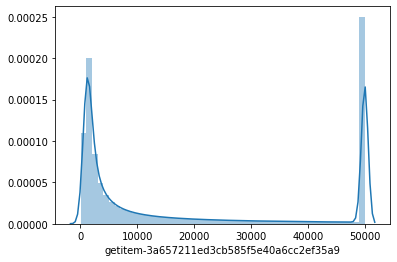

In [30]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\bai"
bai_features = dd.read_parquet(os.path.join(path,'bai_features.parquet'), index='pixel_id' )

sb.distplot(bai_features.value_max.values[~np.isnan(bai_features.value_max.values)])

In [32]:
client.close()
del bai_features

#### Normalized Difference Vegetation Index Statistics

In [3]:
client = Client(n_workers=7, 
                processes=True, memory_limit='15GB')
client

Client Scheduler: tcp://127.0.0.1:57346 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 7 Cores: 14 Memory: 105.00 GB


In [4]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject\ndvi"
df = dd.read_parquet(os.path.join(path,'my_df_no_missing.parquet'), index='pixel_id' )
ndvi_features = df.groupby('pixel_id').agg({'value': ['max','mean','min']}).compute()
ndvi_features.columns = ["_".join(x) for x in ndvi_features.columns.ravel()]

ndvi_features.to_parquet(os.path.join(path,'ndvi_features.parquet'), compression ='UNCOMPRESSED' )
client.close()

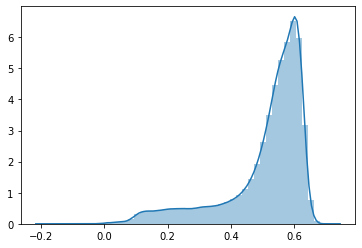

Future exception was never retrieved
future: <Future finished exception=TimeoutError('Timeout',)>
tornado.util.TimeoutError: Timeout


In [5]:
sb.distplot(ndvi_features.value_max.values)


#### Combine BAI and NDVI features 
Combine features to a single file.

In [8]:
path = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\reproject"
bai_features =  dd.read_parquet(os.path.join(path,'bai','bai_features.parquet'), index='pixel_id' )
bai_features.columns = ['bai_max', "bai_mean", 'bai_min']
ndvi_features =  dd.read_parquet(os.path.join(path,'ndvi','ndvi_features.parquet'), index='pixel_id' )
ndvi_features.columns = ['ndvi_max', "ndvi_mean", 'ndvi_min']


In [9]:
ndvi_features.persist()
bai_features.persist()


,bai_max,bai_mean,bai_min
npartitions=2,,,
0,float64,float64,float64
32917077,...,...,...
65834152,...,...,...


In [10]:
combined_features = dd.concat([bai_features, ndvi_features], axis=1).compute()


In [11]:
combined_features.fillna(combined_features.mean(), inplace=True)
print(combined_features.head())

            bai_max   bai_mean    bai_min  ndvi_max  ndvi_mean  ndvi_min
pixel_id                                                                
0         1537.8351  1537.8351  1537.8351  0.485552   0.385334  0.285117
1         1289.7305  1289.7305  1289.7305  0.476450   0.376513  0.276576
2         1280.9679  1280.9679  1280.9679  0.468452   0.358194  0.247936
3         1805.2908  1805.2908  1805.2908  0.463188   0.330371  0.197555
4         2039.8162  2039.8162  2039.8162  0.483314   0.326562  0.169810


 #### Convert files back to raster format

bai_max
bai_mean
bai_min
ndvi_max
ndvi_mean
ndvi_min


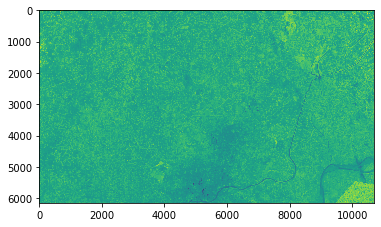

In [46]:
# convert TS features  back to raster 
example_raster = r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\combine\all_merge_clip.tif"
ex_row, ex_cols =  rasterio.open(example_raster).shape

for column in combined_features.columns:
    print(column)
    f2Array =  combined_features[column].values.reshape(ex_row, ex_cols)
    plt.imshow(f2Array)

    output_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features\\'+column+'.tif' 

    with rasterio.open(example_raster) as src_dataset:

        kwds = src_dataset.profile
        kwds.update({
                'dtype': 'float32',
                'nodata': -9999
                })  

        with rasterio.open(output_raster, 'w', **kwds) as dst_dataset:
            # Write data to the destination dataset.
            dst_dataset.write_band(1, np.float32(f2Array))

## Example supervised classification
 

### Read in training data
Here we will focus on multiclass_points_new which contains training data points generated by looking at false composite (4,3,2) images to classify urban, water, harvested and unburnt, burnt, and standing vegetation.

In [30]:
burn_points = gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\burnt_unburnt.shp")
right_cluster = gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\right_cluster.shp")
burn_points_new = gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\New_burned_training.shp")
multiclass_points_new = gpd.read_file(r"C:\Users\mmann\Dropbox\IFPRI_Fire_India\Shapefiles\new_multiclass_burned.shp")


output_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\classifications\knn_scaled.tif'
example_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features\bai_max.tif'

# reproject
burn_points = burn_points_new.to_crs(rasterio.open(output_raster).crs)
burn_points.head()

,Id,Burned,geometry
0,0,burned,POINT (727293.1294438748 3344400.528301735)
1,0,burned,POINT (727349.3535146562 3344536.127531266)
2,0,burned,POINT (727531.2549201257 3345045.451466581)
3,0,burned,POINT (724667.1346085519 3344860.24276283)
4,0,burned,POINT (724663.8273102705 3344916.466833612)


Limit points to bounds of image

In [31]:
with rasterio.open(example_raster) as src_dataset:
    print(src_dataset.bounds)
    df = gpd.GeoDataFrame(gpd.GeoSeries(src_dataset.bounds), 
                          columns=['geometry'])
df

# limit multiclass_points_new to right cluster of points (clipping)
xmin, ymin, xmax, ymax = df.geometry
multiclass_points_new = multiclass_points_new.cx[xmin:xmax, ymin:ymax]
multiclass_points_new.reset_index(inplace=True)  # reset index
print(multiclass_points_new.shape)
multiclass_points_new.index

# remove 
multiclass_points_new.Class[multiclass_points_new.Class == 'uarban'] = 'urban'

BoundingBox(left=703764.0, bottom=3333195.0, right=735873.0, top=3351648.0)
(314, 4)


Extract values to new training points

In [32]:
features = []
names = []
for feature in glob(r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features\*.tif'): 
    feature_value = point_query(multiclass_points_new, 
                               raster=feature,
                               interpolate='nearest')
    names.append(os.path.basename(os.path.splitext(feature)[0]))
    features.append(feature_value)
    
print(names)
features = list(zip(*features)) # transpose
 

['bai_max', 'bai_mean', 'bai_min', 'ndvi_max', 'ndvi_mean', 'ndvi_min']


In [35]:
# check time series feature values for points
point_features = pd.DataFrame( features , columns=names)
point_features.head()

,bai_max,bai_mean,bai_min,ndvi_max,ndvi_mean,ndvi_min
0,29793.279297,15123.362305,453.443970,0.197807,0.118965,0.059763
1,989.442078,844.564880,699.687622,0.608914,0.256019,0.069585
2,4994.685547,3030.702881,1066.720215,0.604659,0.262779,0.075207
3,4317.822266,2763.947998,1210.073730,0.592439,0.303330,0.126570
4,1148.458374,1076.019287,1003.580078,0.577924,0.294668,0.138086


In [36]:
# check dependent value classifications for points
multiclass_points_new['Class'].value_counts()

burned       102
unharvest     80
harvest       64
urban         40
water         28
Name: Class, dtype: int64

  ### Model Training
  Create testing training split stratified by y classes. 

In [50]:
from sklearn.model_selection import train_test_split as tts
y = multiclass_points_new.iloc[:,2]
X = point_features.iloc[:,:]
X_train, X_test, y_train, y_test = tts(X, y,
                                           test_size=0.8,
                                           stratify=y,
                                           random_state=42)

Create parameter search grid for randomized search cross-validation for random forest

In [51]:
from sklearn.model_selection import RandomizedSearchCV# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid) 

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


Fit random forest model

In [52]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)# Fit the random search model
rf_random.fit(X_train,  y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.0s finished
C:\Users\mmann\AppData\Local\Continuum\anaconda2\envs\ts-rasterv3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

#### Measure out of sample performance


In [53]:
predict_test = rf_random.predict(X=X_test)

test_acc = accuracy_score(y_test, predict_test)
kappa = cohen_kappa_score(y_test, predict_test)
confusion = confusion_matrix(y_test, predict_test)

print('Testing accuracy:',test_acc)
print('Testing Kappa: ',kappa)
print('Testing Conf: ')
pd.DataFrame(confusion,columns= list(rf_random.classes_),index=list(rf_random.classes_))

Testing accuracy: 0.7896825396825397
Testing Kappa:  0.7220395421436004
Testing Conf: 


,burned,harvest,unharvest,urban,water
burned,65,10,6,1,0
harvest,23,27,1,0,0
unharvest,3,0,61,0,0
urban,1,0,0,28,3
water,2,0,0,3,18


(5, -0.5)

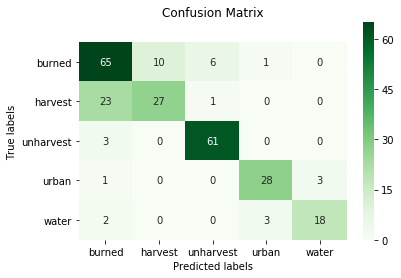

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(confusion, annot=True, cmap='Greens',ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(rf_random.classes_)); ax.yaxis.set_ticklabels(list(rf_random.classes_),rotation=0);
ax.set_ylim(len(list(rf_random.classes_)),-0.5,-1)

In [55]:
feature_importances = pd.DataFrame(rf_random.best_estimator_.feature_importances_,
                                   index = X_test.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
 
feature_importances

,importance
ndvi_min,0.243481
ndvi_mean,0.195528
ndvi_max,0.185064
bai_min,0.138315
bai_mean,0.138232
bai_max,0.099379


Make predictions back to the full original dataset

In [ ]:
# extract point values for prediction
#path = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features'
#rasters = tr.image_to_series(path)

In [259]:
path = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features'
rasters.to_csv(os.path.join(path,'features_df.csv'), chunksize=10000, index=False)
rasters.head()

,pixel_id,time,value,kind
0,0,max,1537.835083,bai
1,0,mean,1537.835083,bai
2,0,min,1537.835083,bai
3,0,max,0.485552,ndvi
4,0,mean,0.385334,ndvi


In [18]:
rasters['kind_type'] =rasters['kind'].astype(str) +'_'+ rasters['time'].astype(str)
rasters.drop(['time','kind'],axis=1,inplace=True)
rasters.head()

,pixel_id,time,value,kind,kind_type
0,0,max,1537.835100,bai,bai_max
1,0,mean,1537.835100,bai,bai_mean
2,0,min,1537.835100,bai,bai_min
3,0,max,0.485552,ndvi,ndvi_max
4,0,mean,0.385334,ndvi,ndvi_mean


convert from long to wide format

In [27]:
rasters = rasters.pivot(index='pixel_id', columns='kind_type', values='value')
rasters.head()

kind_type,bai_max,bai_mean,bai_min,ndvi_max,ndvi_mean,ndvi_min
pixel_id,,,,,,
0,1537.8351,1537.8351,1537.8351,0.485552,0.385334,0.285117
1,1289.7305,1289.7305,1289.7305,0.476450,0.376513,0.276576
2,1280.9679,1280.9679,1280.9679,0.468452,0.358194,0.247936
3,1805.2908,1805.2908,1805.2908,0.463188,0.330372,0.197555
4,2039.8162,2039.8162,2039.8162,0.483314,0.326562,0.169810


In [28]:
#store
path = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features'
rasters.to_csv(os.path.join(path,'features_df_wide.csv'), chunksize=50000, index=False)

In [ ]:
path = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\ts_features\features_df_wide.csv'
rasters = pd.read_csv(path)

#### make prediction of class


In [56]:
# returns class prediction
all_predict = md.model_predict(model = rf_random,
                                new_X = rasters)

# returns probability of each class
all_prob =  md.model_predict_prob(model = rf_random,
                                  new_X = rasters)
 

Convert text categories to numbers

In [63]:
print(all_predict.unique())
cleanup_nums = {"unharvest": 1, "harvest": 2,'burned':3,'urban':4,'water':5 }
all_predict.replace(cleanup_nums, inplace=True)     
print(all_predict.unique())

['unharvest' 'harvest' 'burned' 'urban' 'water']
[1 2 3 4 5]


Plot land use classification

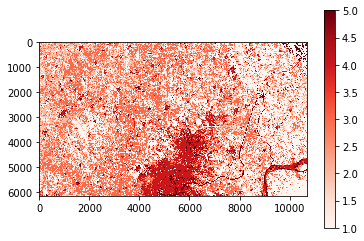

In [64]:
# convert classification  back to raster 

raster_ex = os.path.join(path,'bai_max.tif')
ex_row, ex_cols =  rasterio.open(raster_ex).shape

f2Array = all_predict.values.reshape(ex_row, ex_cols)
 # Plot the grid

plt.imshow(f2Array)
plt.set_cmap("Reds")
plt.colorbar( )
plt.show()

C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\classifications\\all_predict.tif


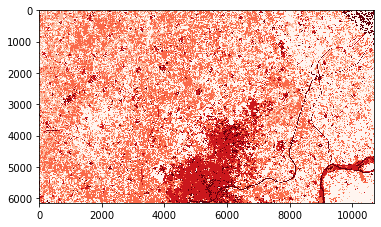

In [75]:
# convert preds back to raster 
ex_row, ex_cols =  rasterio.open(raster_ex).shape

for column in [all_predict]:
    #print(column)
    f2Array =  column.values.reshape(ex_row, ex_cols)
    plt.imshow(f2Array)

    output_raster = r'C:\Users\mmann\Dropbox\IFPRI_Fire_India\Images_new\classifications\\all_predict.tif' 
    print(output_raster)
    with rasterio.open(example_raster) as src_dataset:

        kwds = src_dataset.profile
        kwds.update({
                'dtype': 'int16',
                'nodata': -9999
                })  

        with rasterio.open(output_raster, 'w', **kwds) as dst_dataset:
            # Write data to the destination dataset.
            dst_dataset.write_band(1, np.int16(f2Array))